<a href="https://colab.research.google.com/github/AnIsAsPe/RNN-Resumenes-de-Texto/blob/main/Notebooks/Resumen_de_textos_usando_seq2seq_LSTM_w2v.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cargar bibliotecas

In [1]:
!pip install contractions

     |████████████████████████████████| 286kB 8.5MB/s 
     |████████████████████████████████| 327kB 26.0MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85394 sha256=273c05346fdf6edae31a3f2047fb6f8b6ff88c5b6fbd1fefbb6558f9c6b544a2
  Stored in directory: /root/.cache/pip/wheels/3a/03/34/77e3ece0bba8b86bfac88a79f923b36d805cad63caeba38842
Successfully built pyahocorasick


In [2]:
import pandas as pd
import numpy as np

import gensim
import contractions
import re

import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt

## Descomprimir archivo

In [3]:
#from zipfile import ZipFile
#with ZipFile('/content/drive/MyDrive/Datos/ReviewsAmazon.csv.zip', 'r') as zip_ref:
#    zip_ref.extractall('/content/drive/MyDrive/Datos/AmazonReviews')

# Leer datos de entrada

In [4]:
df = pd.read_csv('/content/drive/MyDrive/Datos/AmazonReviews/Reviews.csv',
                 nrows=100000, usecols=['Summary', 'Text'], )
df = df.drop_duplicates(keep='first', ignore_index = True).dropna()
print(df.shape)
df.head()

(88563, 2)


,Summary,Text
0,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,"""Delight"" says it all",This is a confection that has been around a fe...
3,Cough Medicine,If you are looking for the secret ingredient i...
4,Great taffy,Great taffy at a great price. There was a wid...


In [5]:
np.random.seed = 15
muestra = np.random.choice(range(len(df)), 5)
for i in muestra:
    print("\nReview #", i)
    print(df.loc[i, 'Summary'])
    print(df.loc[i,'Text'])    


Review # 27839
I thought the ingredients sounded yummy...
unfortunately my dog doesn't agree.<br /><br />I have to count these cookies as a loss and reorder <a href="http://www.amazon.com/gp/product/B003VD8DSO">Three Dog Bakery Bitty Bites, Baked Dog Treats, Assorted Flavors, 13 ounces</a>.<br /><br />I'm only giving it two starts because I like the wholesome ingredients this brand uses.

Review # 8149
Tasteful Tazo Tea
Tazo Sweet Cinnamon Spice Tea is a very tasteful tea with no unpleasant after taste. I am not sure what a person can say about tea, but this flavor is one of the best I have ever had. It makes great hot tea or iced tea. It's pleasant flavor is a treat all by itself and is excellent without any sweetener.<br /><br />Some teas leave a bitter or strange after taste but this tea does not. Every cup is very special. Even if you leave the tea bag in your cup for a long time, it never gets bitter. Wonderful product!<a href="http://www.amazon.com/gp/product/B000E1588O">Tazo Sw

In [6]:
df.to_csv('Amazon_reviews_trim.csv', index=False)

# Preprocesamiento de texto
- convertir a minuscualas
- expandir contracciones
- eliminar puntuación


In [7]:
def preprocesar(texto):
    #quitar contracciones
    texto = contractions.fix(texto)

    #convertir en minúsculas
    texto = texto.lower()

    # eliminar texto no deseado
    texto = re.sub(r'<br />', ' ', texto)

    #texto = re.sub(r'https?:\/\/.*[\r\n]*', '', texto, flags=re.MULTILINE)
    #texto = re.sub(r'\<a href', ' ', texto)
    #texto = re.sub(r'&amp;', '', texto) 
    #texto = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', texto)
    #texto = re.sub(r'\'', ' ', texto)

    #dejar solo letras y números
    texto = re.sub('[^A-ZÜÖÄa-z0-9]+', ' ', texto)
    return(texto)

In [8]:
%%time
for col in df.columns:
  df[col] = df[col].apply(preprocesar)
  
df.loc[738,'Text']

CPU times: user 7.5 s, sys: 35.4 ms, total: 7.54 s
Wall time: 7.56 s


In [9]:
df['Summary'] = df['Summary'].apply(lambda x : 'tokenstart '+ x + ' tokenend')  #Identificador de comienzo y término

In [10]:
np.random.seed = 15
muestra = np.random.choice(range(len(df)), 5)
for i in muestra:
    print("\nReview #", i)
    print(df.loc[i, 'Summary'])
    print(df.loc[i,'Text'])    


Review # 54301
tokenstart ditto tokenend
i am a low carb dieter and these noodles are great one serving has 0 net carbs i agree they are not a good replacement for spaghetti noodles for those i still stick to the shiritaki noodles they are the best for stir fry and salads though they do not have any flavor but they have a really nice crisp texture 

Review # 83216
tokenstart so easy a man age 63 can do it  tokenend
easy to prepare good cheesy flavor even i can do it i did realize after trying other velveeta cheesy skillets that there is plenty of cheese to enlarge upon what is in the skillet my own adaptation included chicken first cooked on the grill adding extra broccoli from the garden some bell banana and jalapeno peppers roma tomatoes and mushrooms fresh or canned more bulk less calories per serving except i could not stop eating with only one serving i cooked that good amazing these cheesy skillet boxes also i found that doritos chips went great with this dish rather than the cu

# Limitar la cantidad de palabras en textos y resumenes

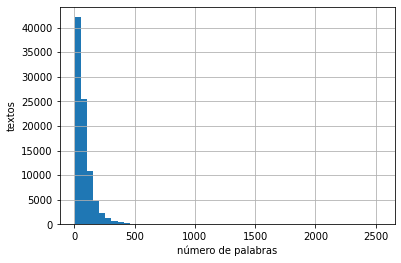


El 90% de los textos tiene 168 palabras


In [11]:
# ¿Cuantas palabras tienen cada texto?
palabras_textos = df['Text'].apply(lambda x: len(str(x).split()))

hist = palabras_textos.hist(bins=50)
hist.set_xlabel("número de palabras")
hist.set_ylabel("textos")
plt.show()

print('\nEl 90% de los textos tiene {:,.0f} palabras'.format(palabras_textos.quantile(0.90)))

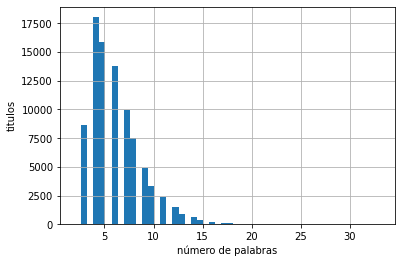


El 97.5% de los titulos tiene 13 palabras


In [12]:
# ¿Cuantas palabras tienen cada titulo?
palabras_titulos = df['Summary'].apply(lambda x: len(str(x).split()))

hist = palabras_titulos.hist(bins=50)
hist.set_xlabel("número de palabras")
hist.set_ylabel("titulos")
plt.show()

print('\nEl 97.5% de los titulos tiene {:,.0f} palabras'.format(palabras_titulos.quantile(0.975)))

In [13]:
longitud_max_textos = palabras_textos.quantile(0.90)     #168 palabras
longitud_max_titulos = palabras_titulos.quantile(0.975)  # 13 palabras

In [14]:
datos =  df[(palabras_textos <= longitud_max_textos ) | (palabras_titulos <= longitud_max_titulos)]
datos.shape   

(87978, 2)

# Dividir datos en conjunto de entrenamiento y prueba

In [15]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(datos['Text'], 
                                                    datos['Summary'], 
                                                    test_size=0.1, 
                                                    shuffle=True, 
                                                    random_state=0)

# Vectorización del texto

[Referencia](https://keras.io/examples/nlp/pretrained_word_embeddings/):


In [16]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization  
from tensorflow.data import Dataset

### Paso 1 Diccionario de vocabulario con clave y vectorizador de textos

In [17]:
def genera_dic_vocabulario(serie_pd, max_tokens= 20000):
  '''Obtiene el vocabulario de una serie de pandas con textos en forma de 
  diccionario, donde cada palabra es una clave y el valor es un indice'''
  vectorizer = TextVectorization(max_tokens = max_tokens  )  
  text_ds = Dataset.from_tensor_slices(serie_pd).batch( 128)  
  vectorizer.adapt(text_ds)   #similar a fit 
  voc = vectorizer.get_vocabulary()  # lista con el vocabulario
  #diccionario con el vocabulario
  dic_vocabulario = dict(zip(voc, range(len(voc))))
  return dic_vocabulario, vectorizer

In [18]:
%%time
vocabulario_dic, vectorizer_reseña = genera_dic_vocabulario(x_train)

CPU times: user 4.21 s, sys: 427 ms, total: 4.63 s
Wall time: 9.2 s


In [19]:
ejemplos = ['got', 'wild', 'hair', 'ordered', 'pound', 'bag']
[vocabulario_dic[palabra] for palabra in ejemplos]

[148, 1081, 502, 197, 614, 111]

In [20]:
vectorizer_reseña(ejemplos)

<tf.Tensor: shape=(6, 1), dtype=int64, numpy=
array([[ 148],
       [1081],
       [ 502],
       [ 197],
       [ 614],
       [ 111]])>

In [21]:
vocabulario_dic.keys()

dict_keys(['', '[UNK]', 'the', 'i', 'and', 'a', 'it', 'to', 'is', 'of', 'this', 'not', 'for', 'in', 'that', 'my', 'have', 'but', 'you', 'are', 'with', 'was', 'they', 'as', 'on', 'like', 'so', 'these', 'them', 'good', 'be', 'will', 'can', 'or', 'at', 'taste', 'just', 'one', 'do', 'if', 'product', 'would', 'very', 'great', 'all', 'flavor', 'am', 'from', 'coffee', 'we', 'when', 'more', 'has', 'tea', 'had', 'me', 'love', 'food', 'than', 's', 'out', 'no', 'other', 'get', 'amazon', 'some', 'up', 'really', 'about', 'only', 'too', 'much', 'an', 'there', 'because', 'your', 'were', 'also', 'time', 'little', 'did', 'use', 'what', 'he', 'buy', 'which', 'price', 'dog', 'she', 'tried', 'best', 'does', 'well', 'by', 'make', 'been', 'even', 'chocolate', 'find', 'better', 'try', 'after', 'eat', 'any', 'now', 'first', '2', 'sugar', 'drink', 'their', 'could', 'bag', 'our', 'cup', 'water', 'her', 'then', 'again', 'found', 'used', 'sweet', 'made', '1', 'box', 'think', 'bought', 'way', 'two', 'over', 'free'

In [22]:
len(vocabulario_dic)

20000

[UNK] se usa para cuando en nuevos ejemplos existan palabras que no se enciuentren en el diccionario.

### Paso 2 Diccionario con vectores de palabras (embeddings) Word2Vec# 
Bajaremos los vectores word2vec preentrenados con el corpus GoogleNews.
Cuenta con 3 millones vectores de 300 dimensiones correspondientes a 3  palabras y frases en inglés


Referencia uso word embedings preentrenados con Keras en este [enlace](https://keras.io/examples/nlp/pretrained_word_embeddings/)


In [23]:
#!wget wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"
#!gunzip /content/GoogleNews-vectors-negative300.bin.gz -d /content/drive/MyDrive/Datos/Embeddings/

In [24]:
from gensim.models import KeyedVectors  #comparación keyedVectors y fullmodels https://radimrehurek.com/gensim/models/keyedvectors.html

w2v = gensim.models.KeyedVectors.load_word2vec_format('/content/drive/MyDrive/Datos/Embeddings/GoogleNews-vectors-negative300.bin',
                                                        binary=True)

In [25]:
%%time
dic_embeddings_word2vec  = {palabra : w2v[palabra] for palabra in w2v.index2word}

CPU times: user 6.46 s, sys: 258 ms, total: 6.72 s
Wall time: 6.73 s


In [26]:
#Cantidad de palabras en modelo word2vec
len(dic_embeddings_word2vec)

3000000

In [27]:
print(dic_embeddings_word2vec ["got"].shape)
dic_embeddings_word2vec ["got"]

(300,)


array([ 0.06201172,  0.10839844, -0.09667969,  0.07910156,  0.03393555,
       -0.34765625, -0.06982422, -0.05249023, -0.1328125 ,  0.19140625,
       -0.04882812, -0.25195312, -0.00817871, -0.00964355, -0.05444336,
       -0.02270508,  0.10498047,  0.24511719,  0.01953125,  0.06933594,
       -0.18652344,  0.13671875,  0.30664062, -0.07324219,  0.26953125,
       -0.04589844,  0.04223633, -0.02502441,  0.14941406,  0.09228516,
        0.07519531,  0.02160645, -0.1015625 , -0.03710938,  0.15234375,
        0.02807617,  0.11083984,  0.00108337,  0.01696777,  0.03540039,
       -0.05224609, -0.2890625 ,  0.2265625 ,  0.09423828, -0.01452637,
       -0.12451172, -0.01977539, -0.23144531,  0.08105469, -0.02453613,
       -0.19140625,  0.16015625,  0.00387573, -0.01293945,  0.02294922,
        0.16113281,  0.12792969,  0.05859375,  0.00805664, -0.12695312,
        0.07226562,  0.2109375 , -0.08154297, -0.14453125, -0.05615234,
        0.03442383,  0.03417969, -0.02844238, -0.05029297,  0.14

### Paso 3 Obtener la matriz de vectores para todas las palabras del vocabulario 
embedding_texto()

In [28]:
def embedding_texto(dic_vocabulario, dic_embeddings_palabras, embedding_dim):
    num_tokens = len(dic_vocabulario.keys()) + 2  # se suman dos más para '' y '[UNK]'
    encontradas = 0
    # Inicializar matriz
    embedding_matrix = np.zeros((num_tokens, embedding_dim))
    for word, i in dic_vocabulario.items():
        embedding_vector = dic_embeddings_palabras.get(word)
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            # This includes the representation for "padding" and "OOV"
            embedding_matrix[i] = embedding_vector
            encontradas += 1
    proporcion = encontradas/len(dic_vocabulario) *100
    print("{} palabras vectorizadas, que representan {:.1f}% de todas las palabras en el corpus".format(encontradas, proporcion))
    return embedding_matrix

In [29]:
embedding_matrix = embedding_texto(vocabulario_dic, dic_embeddings_word2vec , 300)

17862 palabras vectorizadas, que representan 89.3% de todas las palabras en el corpus


In [30]:
embedding_matrix.shape

(20002, 300)


**Repetiremos el paso 1 y el paso 3 para crear el diccionario de los Resumenes.(el diccionario con vectores GloVe es el mismo)**

In [31]:
vocabulario_dic_sum, vectorizer_sum = genera_dic_vocabulario(y_train)
embedding_matrix_sum = embedding_texto(vocabulario_dic_sum, dic_embeddings_word2vec , 300)
embedding_matrix_sum.shape

11085 palabras vectorizadas, que representan 77.7% de todas las palabras en el corpus


(14277, 300)

## Paso 4. Vectorizar conjunto de entrenamiento y prueba

In [32]:
datos.loc[5,'Text']

'i got a wild hair for taffy and ordered this five pound bag the taffy was all very enjoyable with many flavors watermelon root beer melon peppermint grape etc my only complaint is there was a bit too much red black licorice flavored pieces just not my particular favorites between me my kids and my husband this lasted only two weeks i would recommend this brand of taffy it was a delightful treat '

In [33]:
vectorizer_reseña(datos.loc[5,'Text'])

<tf.Tensor: shape=(73,), dtype=int64, numpy=
array([   3,  148,    5, 1081,  502,   12, 3097,    4,  197,   10,  706,
        614,  111,    2, 3097,   21,   44,   42, 1523,   20,  149,  156,
       2361, 1469, 1329, 6178, 1390, 1133,  462,   15,   69, 1075,    8,
         73,   21,    5,  132,   70,   71,  473,  328,  950,  383,  414,
         36,   11,   15,  798,  996,  578,   55,   15,  370,    4,   15,
        389,   10, 1808,   69,  127,  580,    3,   41,  145,   10,  168,
          9, 3097,    6,   21,    5, 1848,  204])>

In [34]:
x_train[0:10].apply(vectorizer_reseña)

55357    (tf.Tensor(3, shape=(), dtype=int64), tf.Tenso...
64435    (tf.Tensor(12, shape=(), dtype=int64), tf.Tens...
78907    (tf.Tensor(348, shape=(), dtype=int64), tf.Ten...
84916    (tf.Tensor(4148, shape=(), dtype=int64), tf.Te...
23152    (tf.Tensor(27, shape=(), dtype=int64), tf.Tens...
19857    (tf.Tensor(44, shape=(), dtype=int64), tf.Tens...
12473    (tf.Tensor(15, shape=(), dtype=int64), tf.Tens...
58435    (tf.Tensor(10, shape=(), dtype=int64), tf.Tens...
26992    (tf.Tensor(10, shape=(), dtype=int64), tf.Tens...
5139     (tf.Tensor(7081, shape=(), dtype=int64), tf.Te...
Name: Text, dtype: object

In [35]:
%%time
x_train_vec = x_train.apply(vectorizer_reseña)
x_test_vec = x_test.apply(vectorizer_reseña)

y_train_vec = y_train.apply(vectorizer_sum)
y_test_vec = y_test.apply(vectorizer_sum)

CPU times: user 14min 53s, sys: 1min 34s, total: 16min 28s
Wall time: 14min 8s


In [36]:
len(y_train_vec)

79180

In [37]:
 #obtener indices de reseñas a eliminar
 indx =set()
 for i in y_train_vec.index:
   tot_unk = np.isin(y_train_vec[i], 1).sum()
   if tot_unk >= 1:
     indx.add (i)


In [38]:
len(indx)/len(y_train_vec)

0.0

Necesitamos homogeneisar las dimensiones de los tensores, para ello usamos la función pad_sequence 

In [39]:
%%time
from tensorflow.keras.preprocessing.sequence import pad_sequences

x_train_seq  =  pad_sequences(x_train_vec, maxlen = int(longitud_max_textos), padding='post') 
x_test_seq  =  pad_sequences(x_test_vec, maxlen = int(longitud_max_textos), padding='post') 

y_train_seq  =  pad_sequences(y_train_vec, maxlen = int(longitud_max_titulos) , padding='post') 
y_test_seq  =  pad_sequences(y_test_vec, maxlen = int(longitud_max_titulos) , padding='post') 

CPU times: user 1min 16s, sys: 10.4 s, total: 1min 27s
Wall time: 1min 8s


In [40]:
x_train_vec.shape, y_train_vec.shape

((79180,), (79180,))

In [41]:
x_test_vec.shape, y_test_vec.shape

((8798,), (8798,))

# Diseño del modelo

* [referencia1](https://www.analyticsvidhya.com/blog/2019/06/comprehensive-guide-text-summarization-using-deep-learning-python/)

* [referencia2](https://humboldt-wi.github.io/blog/research/information_systems_1920/nlp_text_summarization_techniques/) 

## Diseño del codificador y decodificador

Codificador 3 capas con 3 LTSM y 320 dimensiones latentes


In [42]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Concatenate, Attention
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras import backend as K 


In [43]:
num_tokens_rev = len(vocabulario_dic) + 2
num_tokens_sum = len(vocabulario_dic_sum) + 2
embedding_dim = 300

In [44]:
K.clear_session() 
latent_dim = 320

# CODIFICADOR   ================================================================

encoder_inputs = Input(shape = (int(longitud_max_textos),))

enc_emb_lay = Embedding(num_tokens_rev, embedding_dim,
                    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
                    trainable=False)
enc_emb = enc_emb_lay(encoder_inputs)

#LSTM 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True, return_state=True)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 


# LSTM 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) 

#LSTM 3 
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True) 
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2) 


# DECODIFICADOR ================================================================

decoder_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(num_tokens_sum, embedding_dim,
                    embeddings_initializer=keras.initializers.Constant(embedding_matrix_sum),
                    trainable=False)
dec_emb = dec_emb_layer(decoder_inputs)

#LSTM 
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c]) 




##Attention Layer

Fuente: https://github.com/madhav727/abstractive-news-summary

In [45]:
!cp drive/MyDrive/Datos/attention.py .


In [46]:
from attention import AttentionLayer

In [47]:
attn_layer = AttentionLayer(name='attention_layer') 
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])  #concatena los estados ocultos del codificador y del decodificador para construir el vector de contexto

## Union del modelo

In [48]:
embedding_matrix_sum.shape

(14277, 300)

In [49]:
embedding_matrix_sum.shape[0]

14277

In [50]:
# Unión de la salida del decodificador(distribución del vocabulario probeniente de los resumenes
# y el vector de contexto delmódulo de atención en la capa con activación softmax

decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])
decoder_dense = TimeDistributed(Dense(embedding_matrix_sum.shape[0], activation='softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input) 

# Modelo definitivo
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 



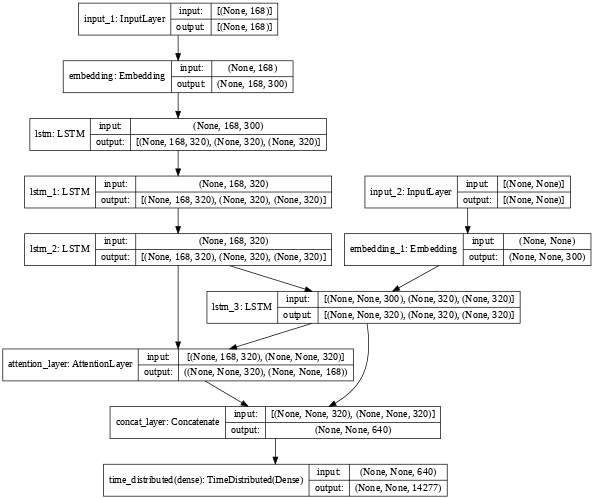

In [51]:
tf.keras.utils.plot_model( 
    model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TD",
    dpi=50,
)

In [52]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 168)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 168, 300)     6000600     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 168, 320), ( 794880      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

# Entrenamiento del modelo

In [53]:
model.compile(optimizer='rmsprop', 
              loss='sparse_categorical_crossentropy')

In [54]:
%%time

from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1) 

history = model.fit([x_train_seq, y_train_seq[:,:-1]], 
                    y_train_seq.reshape(y_train_seq.shape[0],
                                        y_train_seq.shape[1], 1)[:,1:],
                    epochs = 50, 

                    #terminar antes cuando no disminuya la función de pérdida
                    callbacks = [EarlyStopping(monitor='val_loss',mode='min', 
                                             verbose=1)],
                    batch_size = 512, 
                    validation_data = ([x_test_seq,y_test_seq[:,:-1]], 
                                     y_test_seq.reshape(y_test_seq.shape[0],
                                                        y_test_seq.shape[1],
                                                        1)[:,1:]))


Epoch 1/50
155/155 [==============================] - 199s 1s/step - loss: 3.3779 - val_loss: 2.4138
Epoch 2/50
155/155 [==============================] - 159s 1s/step - loss: 2.3264 - val_loss: 2.2032
Epoch 3/50
155/155 [==============================] - 160s 1s/step - loss: 2.1591 - val_loss: 2.1065
Epoch 4/50
155/155 [==============================] - 161s 1s/step - loss: 2.0709 - val_loss: 2.0479
Epoch 5/50
155/155 [==============================] - 161s 1s/step - loss: 1.9686 - val_loss: 1.9893
Epoch 6/50
155/155 [==============================] - 160s 1s/step - loss: 1.8971 - val_loss: 1.9360
Epoch 7/50
155/155 [==============================] - 161s 1s/step - loss: 1.8344 - val_loss: 1.9031
Epoch 8/50
155/155 [==============================] - 161s 1s/step - loss: 1.7671 - val_loss: 1.8730
Epoch 9/50
155/155 [==============================] - 160s 1s/step - loss: 1.7252 - val_loss: 1.8521
Epoch 10/50
155/155 [==============================] - 160s 1s/step - loss: 1.6731 - val_lo

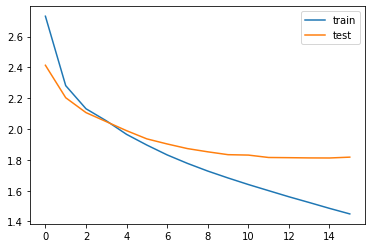

In [55]:
plt.plot(history.history['loss'], label='train') 
plt.plot(history.history['val_loss'], label='test') 
plt.legend() 
plt.show()

In [56]:
#Guardar todo el modelo
model.save('/content/drive/MyDrive/Modelos/rrn_modelo_LSTM_w2v')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Modelos/rrn_modelo_LSTM_w2v/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Modelos/rrn_modelo_LSTM_w2v/assets


In [57]:
#modelo = tf.keras.models.load_model('/content/drive/MyDrive/Modelos/rrn_modelo_w2v')

# Check its architecture
#modelo.summary()

#Invertir diccionario de vocabulario
El objetivo es que a partir de indice, regrese palabras

In [58]:
reversed_vocabulario_dic_sum = dict(map(reversed, vocabulario_dic_sum.items()))
reversed_vocabulario_dic_text = dict(map(reversed, vocabulario_dic.items()))


#Modelo de Inferencia y Generación de Texto

In [59]:
## Inferencia del codificador
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# Inferencia del decodificador

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(int(longitud_max_textos), latent_dim))

# Obtener los embeddings de la secuencia del decodificador 
dec_emb2 = dec_emb_layer(decoder_inputs)

# Para predecir la siguiente palabra, el estado inicial se iguala al estado del tiempo anterior
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#Inferencia en modulo de atención
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# Se utiliza la capa con activación softmax para generar la distribución de probabilidad del vocabulario objetivo
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Modelo final del decoder
decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])

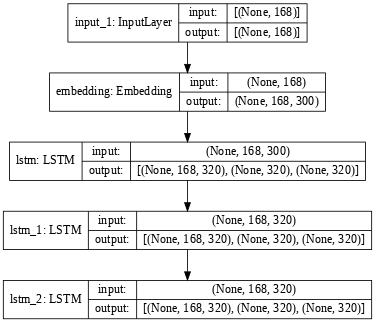

In [60]:
tf.keras.utils.plot_model( 
    encoder_model,
    to_file="encoder_model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TD",
    dpi=60,
)

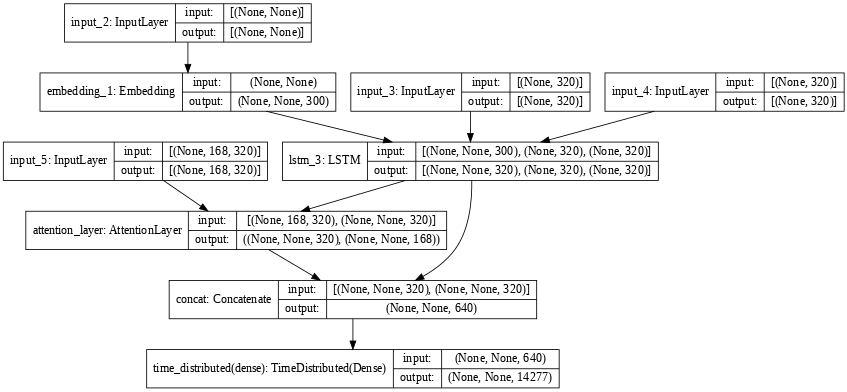

In [61]:
tf.keras.utils.plot_model( 
    decoder_model,
    to_file="model_decoder.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TD",
    dpi=60,
)

# Implementación del modelo de inferencia mediante decode_sequence()

[fuente](https://www.analyticsvidhya.com/blog/2019/06/comprehensive-guide-text-summarization-using-deep-learning-python/)

In [62]:
reversed_vocabulario_dic_sum[0]

''

In [63]:
def crea_resumen(input_seq):
    # Codifica el texto como vectores de entrada
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Genera una secuencia vacía de longitud 1.
    target_seq = np.zeros((1,1))

    # Identifica la palabra 'tokenstart' como la primera palabra de la secuencia objetivo
    target_seq[0, 0] =  vocabulario_dic_sum['tokenstart']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Escoje la proxima palabra para el resumen
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reversed_vocabulario_dic_sum[sampled_token_index]

        # Mientras la palabra elejida no sea la final 'tokenend', anexa la palabra elejida al resumen
        if sampled_token!='tokenend':
            decoded_sentence += ' '+sampled_token

        # Sal del ciclo while si se alcanza la longitud máxima o si se encuentra 'tokenend'.
        if (sampled_token == 'tokenend' or len(decoded_sentence.split()) >= (int(longitud_max_titulos-1))):
                stop_condition = True

        # Actualiza la secuencia objetivo (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Actualiza los estados internos para predecir la siguiente palabra, igualandolos al estado del tiempo anterior
        e_h, e_c = h, c

    return decoded_sentence

In [64]:
def seq2summary(input_seq):
    newString = ''
    for i in input_seq:
      if((i != 0 and i != vocabulario_dic_sum['tokenstart']) and i != vocabulario_dic_sum['tokenend']):
        newString = newString + reversed_vocabulario_dic_sum[i]+' '
    return newString

def seq2text(input_seq):
    newString = ''
    for i in input_seq:
      if(i != 0):
        newString = newString + reversed_vocabulario_dic_text[i]+' '
    return newString

In [65]:
x_test_seq[1]
#.reshape(1, -1)

array([   10,    40,     3,   276,   145,    39,    75,    87,    52,
           5,   601, 10313,    74,     3,   125,    10,    12,    15,
          87,     4,    88,    52,     1,     4,   115, 10313,   412,
         126,   213,     4,     3,    32,   431,   115,   456,    99,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

In [66]:
x_test.iloc[0]

'there are many types of honey mustard pretzel but the snyder honey mustard pieces are the best most flavorful and satisfying to me others just do not compare and are lightly flavored in comparison i love them '

In [67]:
y_test.iloc[0]

'tokenstart honey mustard pretzels tokenend'

In [68]:
for i in range(0, 10):
  print(i)
  print("Review:",seq2text(x_test_seq[i]))
  print("Original summary:",seq2summary(y_test_seq[i]))
  print("Predicted summary:",crea_resumen(x_test_seq[i].reshape(1, -1)))
  print("\n")

0
Review: there are many types of honey mustard pretzel but the snyder honey mustard pieces are the best most flavorful and satisfying to me others just do not compare and are lightly flavored in comparison i love them 
Original summary: honey mustard pretzels 
Predicted summary:  delicious


1
Review: this product i highly recommend if your dog has a huge swelling because i bought this for my dog and she has [UNK] and her swelling went way down and i can open her mouth better 
Original summary: this is a good product 
Predicted summary:  great product


2
Review: i tried congo [UNK] in my friend s house and absolutely love it but since i prefer green tea i have ordered fiji it has great taste hope the quality of the tea also good love fiji and going to try some other flavor from [UNK] 
Original summary: great taste 
Predicted summary:  best green tea


3
Review: i love this tea the full bodied flavor and aroma is smooth and relaxing order the two packs of one hundred the shipping is m